#  欺诈检测/反欺诈
本项目通过利用信用卡的历史交易数据，构建信用卡反欺诈预测模型，提前发现客户信用卡被盗刷的事件。
数据来源Kaggle "Credict Card Fraud": https://www.kaggle.com/mlg-ulb/creditcardfraud

## 一 背景分析和目标确定
### 背景分析

数据集包含欧洲持卡人于2013年9月通过信用卡进行的交易。该数据集提供两天内发生的交易，其中在284,807笔交易中有492起欺诈行为。数据集非常不平衡，负面类别（欺诈）占所有交易的0.172％。

它只包含数值输入变量，这是PCA变换的结果。不幸的是，由于保密问题，我们无法提供有关数据的原始特征和更多背景信息。特征V1，V2，... V28是用PCA获得的主要组件，唯一没有用PCA转换的特征是'Time'和'Amount'。

“时间”：每个事务与第一个事务之间间隔的秒数。
'金额'：交易金额，该特征可以用于依赖于例子的成本敏感性学习。
“Class”：响应变量，在欺诈的情况下其值为1，否则为0。

### 目标确定

构建信用卡反欺诈预测模型，提前发现客户信用卡被盗刷的事件。
————————————————————————————————————————————————————————————————————

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, recall_score, precision_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### 数据加载

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [3]:
pd.set_option("display.max_columns", len(data.columns))
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [17]:
## 判断是否存在缺失值
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## 二 数据探索（特征工程）

### 1 信用卡消费时间的频次

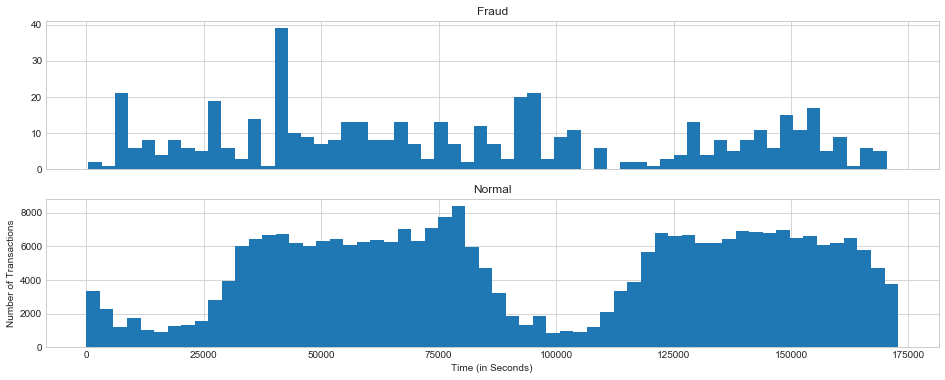

In [4]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))

bins = 60

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

In [5]:
# 为了更清晰的看出每个时间段的消费次数，把时间单位转换成小时（原本的时间单位为秒）
data['Hour'] =data["Time"].apply(lambda x : divmod(x, 3600)[0]) #返回商和余数的元组

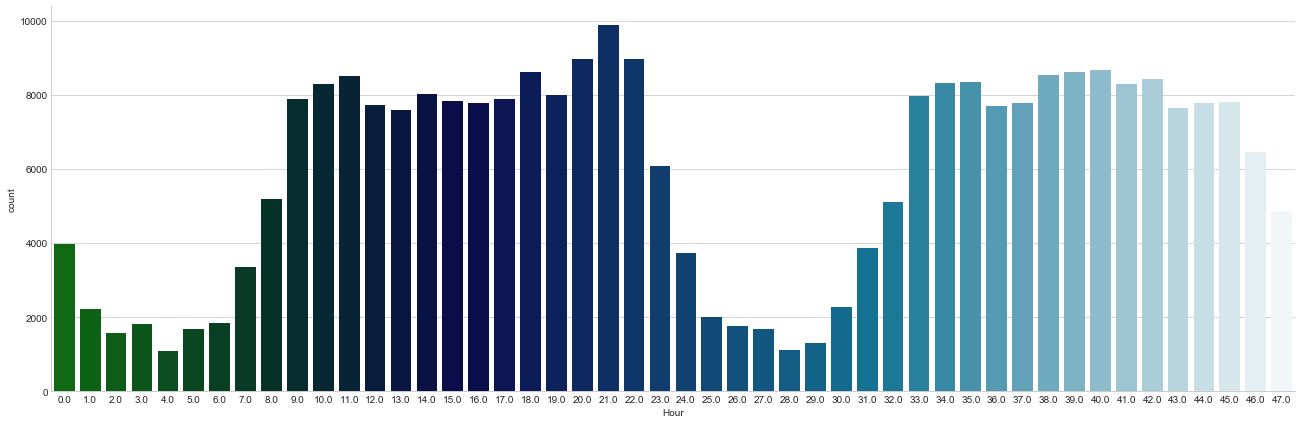

In [6]:
sns.factorplot(x="Hour", data=data, kind="count",  palette="ocean", size=6, aspect=3)

** 分析 **

每天早上9点到晚上11点之间是信用卡消费的高频时间段。
正常交易呈现明显的规律（即9am~11pm）,而被盗刷的信用卡交易则没有这样的规律

### 2 信用卡消费金额的频次

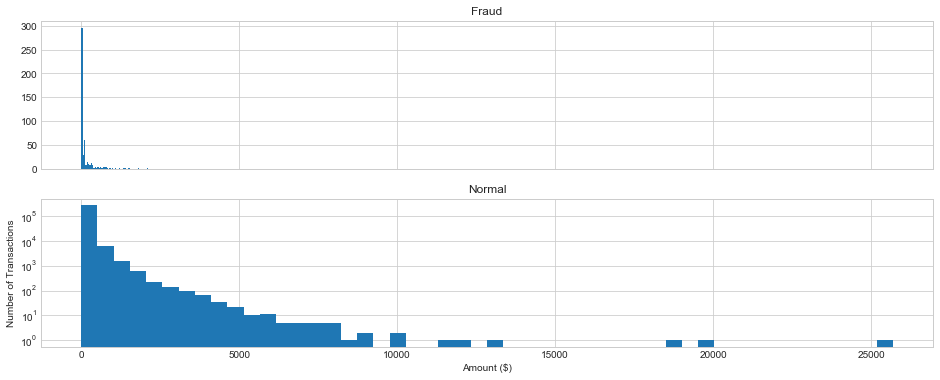

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))

bins = 50

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log', nonposy='clip')
plt.show()

** 分析 **

与正常消费相比，盗刷信用卡的消费金额通常比较小，没有什么大额消费。说明盗刷者为了不引起注意，而选择小额消费。

### 3 盗刷消费/正常消费与时间和金额的关系

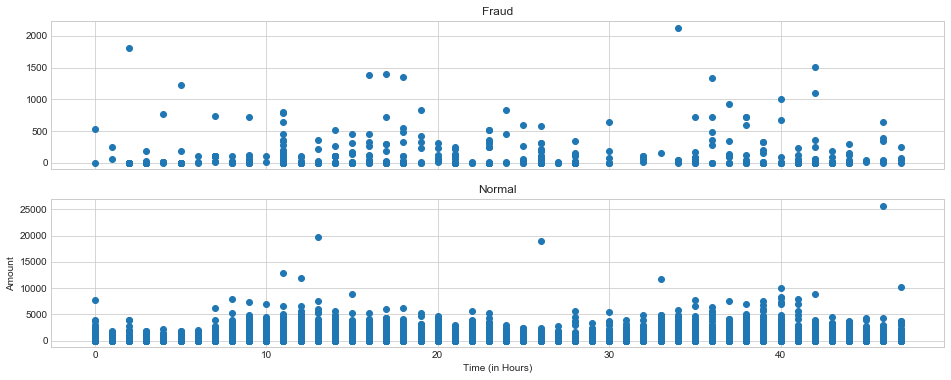

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))

ax1.scatter(data.Hour[data.Class == 1], data.Amount[data.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(data.Hour[data.Class == 0], data.Amount[data.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Hours)')
plt.ylabel('Amount')
plt.show()

** 分析 **

在信用卡被盗刷样本中，离群值多发生在客户使用信用卡消费更低频的时间段。说明在盗刷信用卡中，较大一点金额的的消费往往出现在人们睡觉的时候。

### 4 是否盗刷与各特征变量间的关系

In [10]:
#为了更进一步探索，只选择匿名变量
v_features = data.iloc[:,1:29].columns

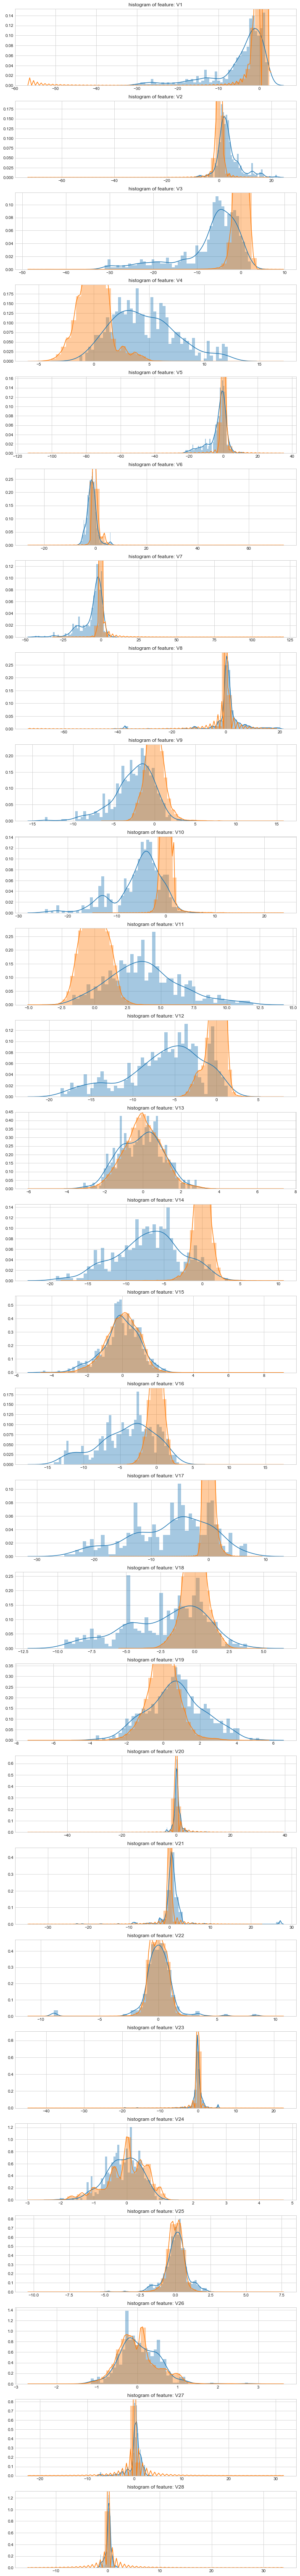

In [11]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1) # 指定子图将放置的网格的几何位置
for i, cn in enumerate(data[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 1], bins=50)
    sns.distplot(data[cn][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

从在信用卡盗刷或正常使用情况下个特征变量的分布情况可以看出，变量V8、V13 、V15 、V20 、V23 、V24 、V27 和V28在这两种情况下的分布大致相同，说明这些变量对判断是否为欺诈消费用处不大。

### 5 特征缩放
各特征之间的大小范围一致，才能使用距离度量等算法.

加速梯度下降算法的收敛.

In [13]:
# 对Amount和Hour 进行特征缩放
data_new = data
col = ['Amount','Hour']
sc =StandardScaler() 
data_new[col] =sc.fit_transform(data_new[col])
data_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,...,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,...,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0,-1.960264
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,...,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0,-1.960264
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,...,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0,-1.960264
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,...,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0,-1.960264
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,...,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0,-1.960264


### 6 使用随机森林对特征的重要性进行排序

In [14]:
x_feature = list(data_new.columns)
x_feature.remove('Class')
x_val = data_new[x_feature]
y_val = data_new['Class']

names = data[x_feature].columns
clf=RandomForestClassifier(n_estimators=10,random_state=0)
clf.fit(x_val, y_val) #对自变量和因变量进行拟合
names, clf.feature_importances_
for feature in zip(names, clf.feature_importances_):
    print(feature)

('Time', 0.0058653095071756972)
('V1', 0.016738422681555006)
('V2', 0.010518840397514637)
('V3', 0.0089007014088101251)
('V4', 0.023488323692359602)
('V5', 0.010402434956637225)
('V6', 0.010577539517821128)
('V7', 0.048717673240922459)
('V8', 0.011611584435865786)
('V9', 0.070517507346816583)
('V10', 0.045277145030190355)
('V11', 0.064095561433761994)
('V12', 0.10533523326883236)
('V13', 0.0082108661101783185)
('V14', 0.16191854031530953)
('V15', 0.010786715709974311)
('V16', 0.059530867061310798)
('V17', 0.14454328027682184)
('V18', 0.032363008884872077)
('V19', 0.018710684824600032)
('V20', 0.019732729293801935)
('V21', 0.016169552255337217)
('V22', 0.0096634393606279973)
('V23', 0.0096416406589046339)
('V24', 0.0066689134217992902)
('V25', 0.007058938720220849)
('V26', 0.024001162723529139)
('V27', 0.0092521682212968887)
('V28', 0.0080987059829771522)
('Amount', 0.014384925821584465)
('Hour', 0.0072175834385905541)


(-1, 31)

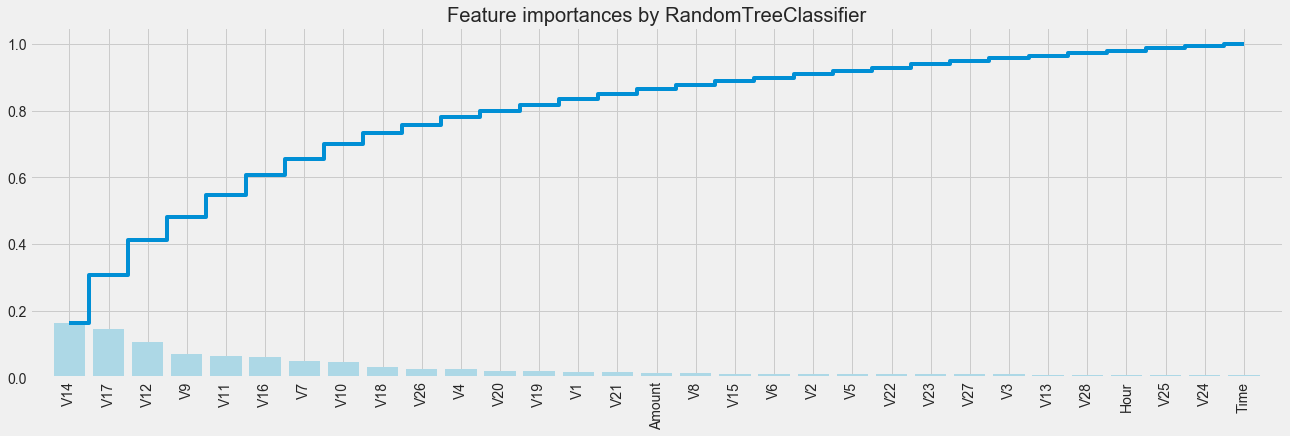

In [15]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

importances = clf.feature_importances_
feature_names = names
indices = np.argsort(importances)[::-1] # 倒序排列
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

### 7 拆分训练集和测试集

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_val, y_val, test_size=0.2, random_state=10)

### 8 处理不平衡样本

从下图中可以看出，欺诈事件仅占总体的0.17%，因此这是一份非常不平衡的数据。样本不平衡会严重影响分类器的学习，比如我们假设所有的事件都为正常事件，那么得到的准确率也会很高。

正常交易事件有284315例,欺诈事件有492例。


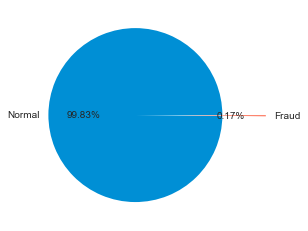

In [29]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
print('正常交易事件有{}例,欺诈事件有{}例。'.format(count_classes[0],count_classes[1]))

labels = 'Normal', 'Fraud'
size = [count_classes[0], count_classes[1]]
explode = [0, 0.5]
plt.axes(aspect=1)
plt.pie(size, labels=labels, explode=explode, autopct='%0.2f%%')
plt.show()

非平衡样本常用的解决方式有2种：1、过采样（oversampling）：增加稀有类样本数，使两类样本接近，然后再进行学习。2、欠采样（undersampling）：去除大类样本数，然后再进行学习。

下采样很可能导致TN(True Negative)过高，对于相同的模型，通常数据越多越好，因此这里使用过采样。

本次处理样本不平衡采用的方法是过采样，具体操作使用SMOTE（Synthetic Minority Oversampling Technique），SMOET的基本原理是：采样最邻近算法，计算出每个少数类样本的K个近邻，从K个近邻中随机挑选N个样本进行随机线性插值，构造新的少数样本，同时将新样本与原数据合成，产生新的训练集。参考了CMU关于SMOTE: Synthetic Minority Over-sampling的介绍 Techniquehttp://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html。

In [30]:
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特征维数：', X.shape[1])


样本个数：284807; 正样本占99.83%; 负样本占0.17%
特征维数： 31


In [31]:
sm = SMOTE(random_state=42)    # 处理过采样的方法
X_sm, y_sm = sm.fit_sample(X_train, y_train)
print('通过SMOTE方法平衡正负样本后')

n_sample = y_sm.shape[0]
n_pos_sample = y_sm[y_sm == 0].shape[0]
n_neg_sample = y_sm[y_sm == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample, n_pos_sample / n_sample, n_neg_sample / n_sample))

通过SMOTE方法平衡正负样本后
样本个数：454894; 正样本占50.00%; 负样本占50.00%


## 三 模型的构建和评估
* 模型的选择：LogisticRegression

计算较为简单，收敛速度快；适用于二分类的大规模数据集处理。

* 评估指标选择：因为我们希望找出所有的欺诈行为，所以recall在这里更重要，因此beta的选择上就要更偏向recall值

* 参数调整：网格搜索交叉验证

In [50]:
clf = LogisticRegression(random_state=10)

parameters = {'C':[0.01,0.1,1,10,100,1000] ,'penalty':['l1','l2']}

scorer = make_scorer(fbeta_score, beta=1.5)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_sm, y_sm)

best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)


print("Final recall_score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))

Final recall_score on the testing data: 0.9043
Final accuracy score on the testing data: 0.9902


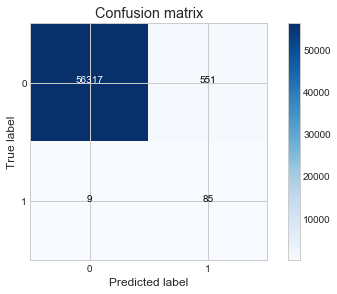

In [44]:
import itertools
cnf_matrix = confusion_matrix(y_test, best_predictions)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()